# Land Cover and Land Use Classification using Satellite Imagery

**Project Overview:** We will engage in a classification task to differentiate various land covers (e.g., water, forest, urban areas) using satellite imagery. This project explores the application of deep learning techniques for analyzing remote sensing data.

## 1. Problem Description

Land cover classification involves identifying and categorizing the physical material on the surface of the Earth. This includes differentiating between various types such as forests, water bodies, agricultural land, urban areas, etc.. Land use, on the other hand, describes how humans utilize the land. Accurately classifying land cover and land use is crucial for numerous applications:

* **Environmental Monitoring:** Tracking deforestation, urbanization, and changes in glaciers or water bodies.
* **Urban Planning:** Managing urban growth and infrastructure development.
* **Agriculture:** Monitoring crop health, and yield estimation.
* **Disaster Management:** Assessing damage after natural disasters like floods or wildfires.
* **Climate Change Studies:** Understanding the impact of climate change on different ecosystems.

Satellite imagery provides a rich source of data for these tasks due to its wide coverage and regular revisit times. However, analyzing this data presents challenges:

* **Cloud Cover:** Clouds can obscure the land surface.
* **Atmospheric Effects:** Atmospheric conditions can distort the spectral information recorded by satellites.
* **Spectral Similarity:** Different land cover types might have similar spectral signatures, making them hard to distinguish.
* **Mixed Pixels:** A single pixel in a satellite image might represent multiple land cover types, especially in lower-resolution imagery.

Deep learning techniques, particularly Convolutional Neural Networks (CNNs), have shown great promise in overcoming these challenges and achieving high accuracy in land cover classification.

## 2. Data Source and Access

This project can utilize datasets from various satellite missions:

* **Sentinel-2:** Provides high-resolution optical imagery across 13 spectral bands, suitable for detailed land cover mapping. The EuroSAT dataset, used in the example code, is derived from Sentinel-2 imagery and contains 27,000 labeled image patches across 10 land cover classes.
* **Sentinel-3 OLCI:** Offers data with wider swath and more frequent revisit times, beneficial for large-area monitoring.

### Accessing Data:

1.  **EuroSAT Dataset:**
    * The EuroSAT dataset is publicly available and comes in two versions: RGB images and multispectral images. For this project, we'll use the RGB version as it's compatible with many pre-trained deep learning models.

2.  **Copernicus Dataspace:**
    * The Copernicus Data Space Ecosystem provides access to a vast archive of Sentinel data.
    * Registration is required to download data. Visit the [Copernicus Dataspace registration page](https://dataspace.copernicus.eu) to create an account.

## 3. Methodology

We can choose between supervised or unsupervised learning approaches:

1.  **Supervised Learning:**
    * This approach requires labeled data, where each image patch is associated with a known land cover class.
    * **Manual Labeling:** We could manually label images using tools like QGIS or IRIS if working with raw satellite data for a custom area. This is time-consuming but allows for tailored dataset creation.
    * **Using Pre-labeled Datasets:** The EuroSAT dataset provides 27,000 labeled images, saving significant effort.
    * **Algorithm:** We will implement a Deep Learning model, specifically a Convolutional Neural Network (CNN), using transfer learning.
2.  **Unsupervised Classification Methods:**
    * These methods do not require labeled data. They group pixels or image patches into clusters based on their inherent properties (e.g., spectral similarity).
    * **Algorithms:** K-Means clustering, or more advanced deep learning-based clustering techniques.
    * **Challenges:** Interpreting the generated clusters can be subjective and may require expert knowledge or comparison with ground truth data if available.
    * This approach is an alternative if labeled data is scarce or unavailable.

**This project will detail the supervised deep learning approach using the EuroSAT dataset and PyTorch.**

## 5. Implementation: Land Cover Classification with PyTorch

The following sections implement the supervised deep learning approach using the EuroSAT dataset.

### 5.1 Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

### 5.2 Configuration

Define paths, class labels, and other constants.

In [ ]:
ROOT_PATH = '/content/drive/My Drive/data'
BASE_PATH = os.path.join(ROOT_PATH, 'EuroSAT_RGB')
DATA_CSV_PATH = os.path.join(ROOT_PATH, 'Dataset')
FULL_DATA_CSV_FILE = os.path.join(DATA_CSV_PATH,'FULL_EUROSAT_DATA.csv')

if not os.path.isdir(DATA_CSV_PATH):
    os.makedirs(DATA_CSV_PATH)

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = list(IDX_CLASS_LABELS.values())
CLASS_IDX_LABELS = {val: key for key, val in IDX_CLASS_LABELS.items()}

NUM_CLASSES = len(CLASSES)
torch.manual_seed(10)
VALID_SIZE = 0.1

### 5.3 Utility Functions

Helper functions for encoding/decoding labels and displaying image batches.

In [ ]:
def encode_label(label):
    return CLASS_IDX_LABELS[label]

def decode_target(target, text_labels=True):
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images.cpu(), nrow=16).permute(1, 2, 0)) #
        break

print(encode_label('Forest'))
print(decode_target(2))

1
HerbaceousVegetation


### 5.4 Data Preprocessing

This step walks through the EuroSAT dataset directory (specified in `BASE_PATH`), collects all image filenames and their corresponding labels, and saves this information into a CSV file (`FULL_DATA_CSV_FILE`). This CSV is then used to load data for training and validation.

In [ ]:
data = []
for class_name in tqdm(os.listdir(BASE_PATH)):
    class_dir = os.path.join(BASE_PATH, class_name)
    if os.path.isdir(class_dir) and class_name in CLASSES:
        for image_file in os.listdir(class_dir):
            if image_file.lower().endswith(('.jpg','.jpeg','.png','.tif','.tiff')):
                data.append({'image_id': image_file, 'label': class_name})

DATA_DF = pd.DataFrame(data)
DATA_DF.to_csv(FULL_DATA_CSV_FILE, index=False)
print(f"Successfully created and saved {FULL_DATA_CSV_FILE} with {len(DATA_DF)} entries.")
print(DATA_DF.head())

DATA_DF = pd.read_csv(FULL_DATA_CSV_FILE)

  0%|          | 0/10 [00:00<?, ?it/s]

Successfully created and saved /content/drive/My Drive/data/Dataset/FULL_EUROSAT_DATA.csv with 27010 entries.
         image_id  label
0   River_402.jpg  River
1  River_2043.jpg  River
2   River_364.jpg  River
3  River_1832.jpg  River
4  River_2452.jpg  River


### 5.5 Splitting Data into Training and Validation Sets

Shuffle the dataset and split it into training and validation sets.

In [ ]:

DATA_DF = DATA_DF.sample(frac=1, random_state=42).reset_index(drop=True)

split_index = int(len(DATA_DF)*(1-VALID_SIZE))
TRAIN_DF = DATA_DF[:split_index]
VALID_DF = DATA_DF[split_index:]
TRAIN_DF.reset_index(drop=True, inplace=True)
VALID_DF.reset_index(drop=True, inplace=True)

print(f"Training set size:{len(TRAIN_DF)}")
print(f"Validation set size:{len(VALID_DF)}")
print("Training DF head:")
print(TRAIN_DF.head())
print("Validation DF head:")
print(VALID_DF.head())

Training set size:24309
Validation set size:2701
Training DF head:
                       image_id                 label
0           AnnualCrop_1736.jpg            AnnualCrop
1  HerbaceousVegetation_996.jpg  HerbaceousVegetation
2              SeaLake_2401.jpg               SeaLake
3           Residential_896.jpg           Residential
4           Residential_532.jpg           Residential
Validation DF head:
               image_id        label
0        River_1854.jpg        River
1      SeaLake_2054.jpg      SeaLake
2    AnnualCrop_156.jpg   AnnualCrop
3  Residential_1935.jpg  Residential
4   AnnualCrop_1264.jpg   AnnualCrop


### 5.6 Creating PyTorch Dataset and DataLoaders

Define a custom `Dataset` class for EuroSAT and create `DataLoaders` for training and validation.

In [ ]:
class EuroSATDataset(Dataset):
    def __init__(self, df, base_image_dir, transform=None):
        self.df = df
        self.base_image_dir = base_image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df) #

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, label_str = row['image_id'], row['label']
        img_path = os.path.join(self.base_image_dir, label_str, img_id)

        try:
            img = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Error: Image not found at {img_path}")
            return None, None
        if self.transform:
            img = self.transform(img)
        return img,encode_label(label_str)

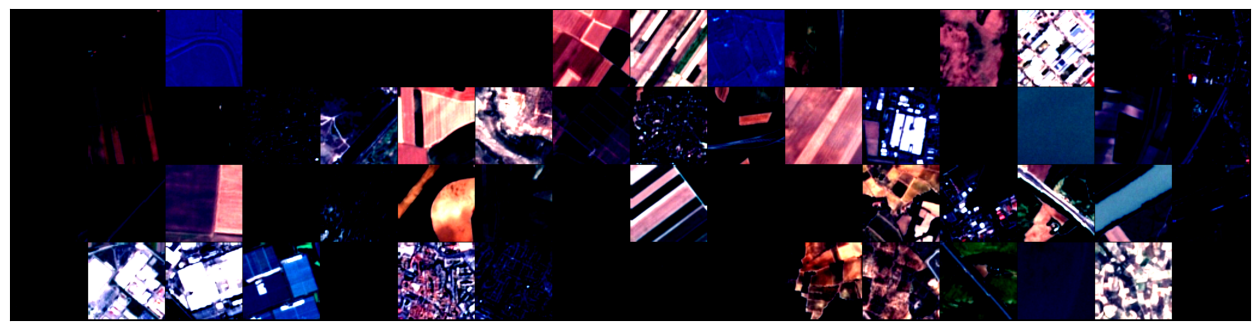

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_ds = EuroSATDataset(TRAIN_DF, BASE_PATH, data_transform)
valid_ds = EuroSATDataset(VALID_DF, BASE_PATH, data_transform)

# DataLoaders
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Show a batch of training images
show_batch(train_dl)

### 5.7 Model Definition

Define the model architecture. We use a pre-trained `wide_resnet50_2` and add a custom classification head.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class MulticlassClassifierBase(nn.Module):
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu, loss

    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}

    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_accu: {:.4f}, lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc'])) #

In [ ]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        # Use pretrained WideResNet50_2
        self.network = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(n_inputs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad = False
        for param in self.network.fc.parameters():
            param.requires_grad = True

    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad = True

model_test_instance = LULC_Model()

### 5.8 Training:

Functions to manage device (GPU) and move data/model to the selected device.

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            if b[0] is not None and b[1] is not None:
                 yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_device()
train_dl_device = DeviceDataLoader(train_dl, device)
valid_dl_device = DeviceDataLoader(valid_dl, device)

model = LULC_Model()
model = to_device(model,device)

### 5.9 Training Loop

The `fit` function handles the model training process over multiple epochs, including optimization, learning rate scheduling, evaluation, and early stopping.

In [ ]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, valid_loader,
        weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD,
        max_epochs_stop=3, model_save_name='lulc_best_model.pth',
        model_max_acc_save_name='lulc_max_acc_model.pth'):

    torch.cuda.empty_cache()
    history = []
    valid_loss_min = np.inf
    valid_acc_max = 0.0
    epochs_no_improve = 0

    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accuracies = []
        lrs = []

        print(f"Starting Epoch {epoch+1}/{epochs}")
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            if batch[0] is None: continue
            accu, loss = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(accu)

            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))

        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        # Store results
        result["train_loss"] = torch.stack(train_losses).mean().item()
        result["train_accu"] = torch.stack(train_accuracies).mean().item()
        result["lrs"] = lrs

        model.epoch_end(epoch, result)
        history.append(result)


        if result['val_acc'] > valid_acc_max:
            print(f"Validation accuracy improved from {valid_acc_max:.4f} to {result['val_acc']:.4f}. Saving model to {model_max_acc_save_name}")
            torch.save(model.state_dict(), model_max_acc_save_name)
            valid_acc_max = result['val_acc']

        if result['val_loss'] < valid_loss_min:
            print(f"Validation loss decreased from {valid_loss_min:.4f} to {result['val_loss']:.4f}. Saving model to {model_save_name}")
            torch.save(model.state_dict(), model_save_name)
            valid_loss_min = result['val_loss']
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"Validation loss did not improve for {epochs_no_improve} epoch(s). Current best: {valid_loss_min:.4f}")
            if epochs_no_improve >= max_epochs_stop:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                return history

    print(f"Training finished. Best validation loss: {valid_loss_min:.4f}, Best validation accuracy: {valid_acc_max:.4f}")
    return history

### 5.10 Training the Model

Set hyperparameters and start the training process. Initially, we'll freeze the base model and train only the classification head. Then, we can unfreeze and fine-tune the entire model.

In [ ]:

epochs = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
criterion = nn.CrossEntropyLoss()
max_epochs_stop_early = 5

# saving models
model_save_dir = os.path.join(ROOT_PATH, 'Models')
if not os.path.isdir(model_save_dir):
    os.makedirs(model_save_dir)

best_loss_model_path = os.path.join(model_save_dir, 'eurosat_best_loss.pth')
max_acc_model_path = os.path.join(model_save_dir, 'eurosat_max_acc.pth')

# evaluate model before training
initial_eval = evaluate(model, valid_dl_device)
print(f"Initial Validation Loss: {initial_eval['val_loss']:.4f}, Initial Validation Acc: {initial_eval['val_acc']:.4f}")

# freeze layers
model.freeze()
history_frozen = fit(epochs=epochs,
            max_lr=max_lr,
            model=model,
            train_loader=train_dl_device,
            valid_loader=valid_dl_device,
            weight_decay=weight_decay,
            grad_clip=grad_clip,
            opt_func=opt_func,
            max_epochs_stop=max_epochs_stop_early,
            model_save_name=best_loss_model_path,
            model_max_acc_save_name=max_acc_model_path)
history = history_frozen

Initial Validation Loss: 2.2908, Initial Validation Acc: 0.1493
Starting Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0], train_accu: 0.7282, lr: 0.000100, train_loss: 1.0885, val_loss: 0.4884, val_acc: 0.8812
Validation accuracy improved from 0.0000 to 0.8812. Saving model to /content/drive/My Drive/data/Models/eurosat_max_acc.pth
Validation loss decreased from inf to 0.4884. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Starting Epoch 2/10


Epoch 2 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1], train_accu: 0.8598, lr: 0.000100, train_loss: 0.4852, val_loss: 0.3274, val_acc: 0.9041
Validation accuracy improved from 0.8812 to 0.9041. Saving model to /content/drive/My Drive/data/Models/eurosat_max_acc.pth
Validation loss decreased from 0.4884 to 0.3274. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Starting Epoch 3/10


Epoch 3 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2], train_accu: 0.8851, lr: 0.000100, train_loss: 0.3724, val_loss: 0.2646, val_acc: 0.9165
Validation accuracy improved from 0.9041 to 0.9165. Saving model to /content/drive/My Drive/data/Models/eurosat_max_acc.pth
Validation loss decreased from 0.3274 to 0.2646. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Starting Epoch 4/10


Epoch 4 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3], train_accu: 0.8997, lr: 0.000100, train_loss: 0.3199, val_loss: 0.2380, val_acc: 0.9277
Validation accuracy improved from 0.9165 to 0.9277. Saving model to /content/drive/My Drive/data/Models/eurosat_max_acc.pth
Validation loss decreased from 0.2646 to 0.2380. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Starting Epoch 5/10


Epoch 5 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4], train_accu: 0.9109, lr: 0.000100, train_loss: 0.2816, val_loss: 0.2117, val_acc: 0.9350
Validation accuracy improved from 0.9277 to 0.9350. Saving model to /content/drive/My Drive/data/Models/eurosat_max_acc.pth
Validation loss decreased from 0.2380 to 0.2117. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Starting Epoch 6/10


Epoch 6 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5], train_accu: 0.9184, lr: 0.000100, train_loss: 0.2577, val_loss: 0.1990, val_acc: 0.9346
Validation loss decreased from 0.2117 to 0.1990. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Starting Epoch 7/10


Epoch 7 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6], train_accu: 0.9249, lr: 0.000100, train_loss: 0.2375, val_loss: 0.1841, val_acc: 0.9364
Validation accuracy improved from 0.9350 to 0.9364. Saving model to /content/drive/My Drive/data/Models/eurosat_max_acc.pth
Validation loss decreased from 0.1990 to 0.1841. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Starting Epoch 8/10


Epoch 8 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7], train_accu: 0.9321, lr: 0.000100, train_loss: 0.2185, val_loss: 0.1744, val_acc: 0.9426
Validation accuracy improved from 0.9364 to 0.9426. Saving model to /content/drive/My Drive/data/Models/eurosat_max_acc.pth
Validation loss decreased from 0.1841 to 0.1744. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Starting Epoch 9/10


Epoch 9 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8], train_accu: 0.9328, lr: 0.000100, train_loss: 0.2087, val_loss: 0.1695, val_acc: 0.9390
Validation loss decreased from 0.1744 to 0.1695. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Starting Epoch 10/10


Epoch 10 Training:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9], train_accu: 0.9363, lr: 0.000100, train_loss: 0.1980, val_loss: 0.1679, val_acc: 0.9412
Validation loss decreased from 0.1695 to 0.1679. Saving model to /content/drive/My Drive/data/Models/eurosat_best_loss.pth
Training finished. Best validation loss: 0.1679, Best validation accuracy: 0.9426


### 5.11 Plotting Training Results

Visualize training and validation loss, accuracy, and learning rates over epochs.

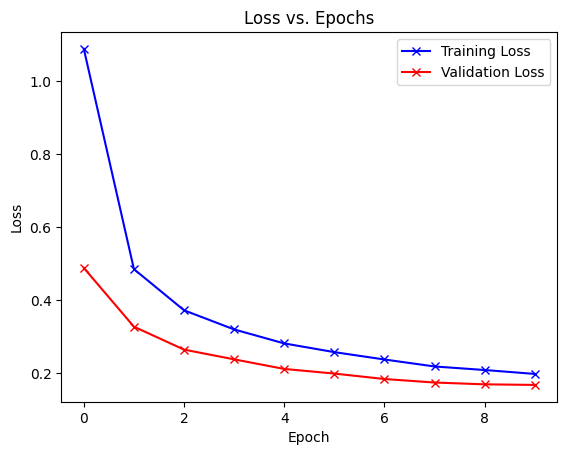

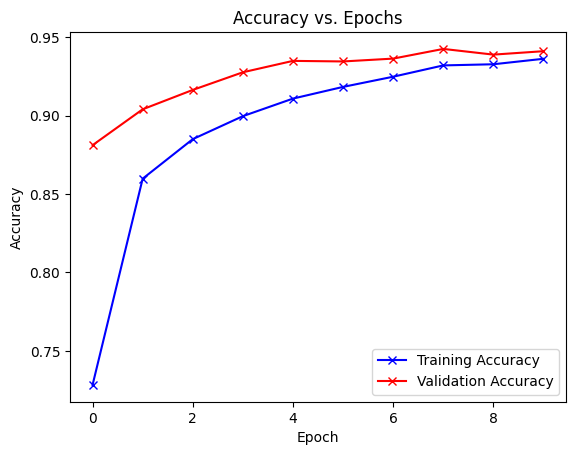

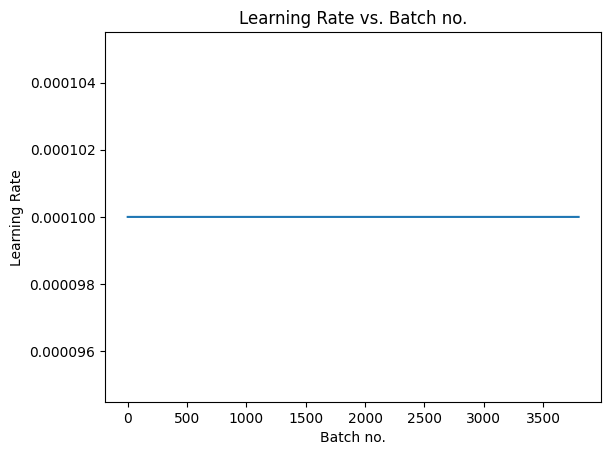

In [ ]:
def plot_losses(history):
    if not history: return
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx', label='Training Loss')
    plt.plot(val_losses, '-rx', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epochs')
    plt.show()

def plot_accuracies(history):
    if not history: return
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx', label='Training Accuracy')
    plt.plot(val_accu, '-rx', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. Epochs')
    plt.show()

def plot_lrs(history):
    if not history: return
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.show()


plot_losses(history)
plot_accuracies(history)
plot_lrs(history)

### 5.12 Prediction and Evaluation on the Validation Set

Load the best model and evaluate its performance on the Validation Set. This includes generating a confusion matrix.

In [ ]:
def predict_single_image(model_loaded, image_tensor, device_to_use):
    model_loaded.eval()
    with torch.no_grad():
        xb = image_tensor.unsqueeze(0)
        xb = to_device(xb, device_to_use)
        preds = model_loaded(xb)
        _, prediction_idx = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(prediction_idx.item(), text_labels=True)

def display_prediction(image_tensor, actual_label_idx, predicted_label_str):
    plt.imshow(image_tensor.permute(1, 2, 0).cpu())
    actual_label_str = decode_target(actual_label_idx)
    plt.title(f"Actual: {actual_label_str}\nPredicted: {predicted_label_str}")
    plt.axis('off')
    plt.show()

best_model_path_to_load = os.path.join(ROOT_PATH, 'Models', 'eurosat_max_acc.pth')
                                                                                # Original notebook used '/content/lulc_max_acc.pth'

loaded_model = LULC_Model()
print(f"Loading best accuracy model from: {best_model_path_to_load}")
loaded_model.load_state_dict(torch.load(best_model_path_to_load, map_location=device))
loaded_model = to_device(loaded_model, device)
loaded_model.eval()

num_samples_to_show = 3
for i in range(min(num_samples_to_show, len(valid_ds))):
    img_tensor, actual_idx = valid_ds[i]
    if img_tensor is not None:
        predicted_class = predict_single_image(loaded_model, img_tensor, device)
        print(f"Sample {i+1}: Actual='{decode_target(actual_idx)}', Predicted='{predicted_class}'")
    else:
        print(f"Sample {i+1} could not be loaded.")


Loading best accuracy model from: /content/drive/My Drive/data/Models/eurosat_max_acc.pth
Sample 1: Actual='River', Predicted='River'
Sample 2: Actual='SeaLake', Predicted='SeaLake'
Sample 3: Actual='AnnualCrop', Predicted='AnnualCrop'


Getting All Predictions:   0%|          | 0/43 [00:00<?, ?it/s]

Overall Validation Accuracy from CM: 0.9430


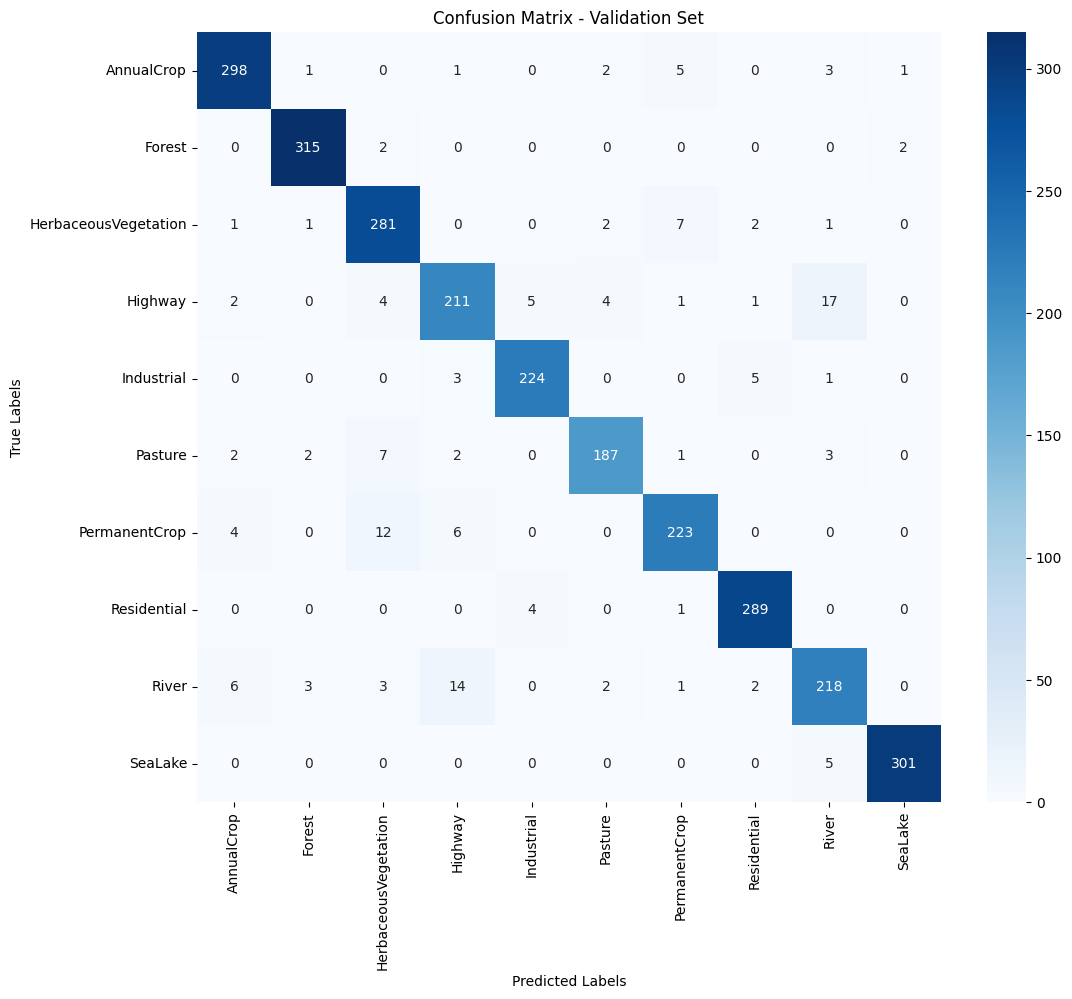

In [ ]:
@torch.no_grad()
def get_all_predictions(model_to_eval, data_loader, device_to_use):
    model_to_eval.eval()
    all_preds = []
    all_labels = []
    for batch in tqdm(data_loader, desc="Getting All Predictions"):
        if batch[0] is None: continue
        images, labels = batch
        outputs = model_to_eval(images)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_all_predictions(loaded_model, valid_dl_device, device)
cm = confusion_matrix(y_true, y_pred)
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Overall Validation Accuracy from CM: {overall_accuracy:.4f}")

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues') #
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

## 8. Assessment of the Environmental Cost

Deep learning projects, especially those involving large datasets and complex models, can have an environmental impact primarily due to the electricity consumed during model training and experimentation. It's important to be mindful of this.

**Key Factors Contributing to Environmental Cost:**

1.  **Computational Resources (Training):**
    * Training deep learning models like `wide_resnet50_2` requires significant GPU or CPU processing time. This is the largest contributor.
    * The energy consumption depends on the hardware used (GPUs are power-intensive), the duration of training, and the efficiency of the code.
    * For this project, training for 10 epochs on the EuroSAT dataset (27000 images of 64x64, upscaled to 224x224) using a platform like Google Colab still consumes energy.

2.  **Data Storage and Transfer:**
    * The EuroSAT dataset (RGB version) is a few gigabytes in size. Storing this data on local drives or cloud storage consumes energy continuously, albeit less than active computation.
    * Downloading the dataset from its source also consumes energy through network infrastructure.

3.  **Hyperparameter Tuning:**
    * Multiple training runs with different hyperparameters (learning rates, batch sizes, model variations) multiply the computational cost.


**Mitigation Strategies :**

* **Transfer Learning:** Using a pre-trained model (`wide_resnet50_2`) significantly reduces the required training time and data compared to training a large model from scratch. This is a major energy-saving practice.
* **Efficient Data Loading:** Using `num_workers` in `DataLoader` can speed up data loading, potentially reducing overall training time if I/O is a bottleneck.
* **Early Stopping:** The implemented early stopping mechanism prevents unnecessary training epochs if the model's performance on the validation set ceases to improve, saving computational resources.
* **Appropriate Batch Size:** Choosing a reasonable batch size helps balance memory usage and training speed.